Free diffusion

In [185]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

In [186]:
# Physical parameters
T_K = 300
k_b = 1.3806452e-23
R_m = 1e-6
m_kg = 1.1e-14 
viscosity_NS_m2 = 0.001
load = 6*np.pi*viscosity_NS_m2*R_m 
rotational_drag = 8*np.pi*viscosity_NS_m2*R_m**3
tau = m_kg/load
einstein_diffusion = k_b*T_K/load
rotational_einstein_diff = k_b*T_K/rotational_drag
dt_s = 100*tau
print("einstein_diffusion coefficient",einstein_diffusion)

einstein_diffusion coefficient 2.197365082360985e-13


In [187]:
# Generating the random sequence

def generate_seq(N):
    standard_deviation = 1 
    W_seq = np.array(np.random.normal(0,standard_deviation,N))
    return W_seq

def walk_free_diffusion(N):
    w = generate_seq(N)
    x = np.zeros(N)
    for i in range(1,N):
        x[i] = x[i-1] + np.sqrt(2*rotational_einstein_diff*dt_s)*w[i]
    return x

In [188]:
def mean_square_displacement(array):
    msd = []
    centered_array = array - np.mean(array)
    for j in range(1,int(len(centered_array))):
        M = np.mean((centered_array[:-j] - centered_array[j:])**2)
        msd.append(M)
    return np.array(msd)

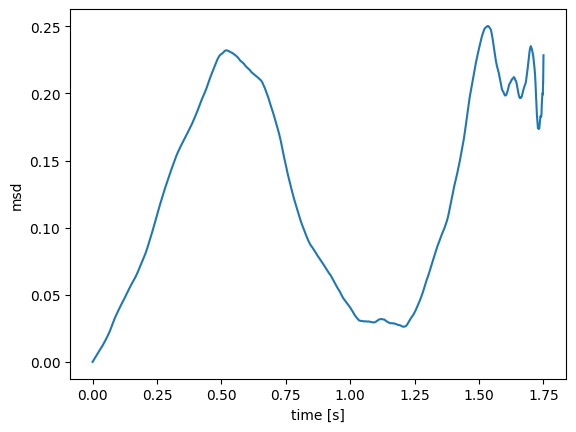

In [189]:
N = 30000
traj_free = walk_free_diffusion(N)
msd_free = mean_square_displacement(traj_free)
t = np.arange(len(msd_free))*dt_s
plt.plot(t,msd_free)
plt.xlabel('time [s]')
plt.ylabel('msd')
plt.show()

Generating W trajectories and computing the respective msd in ordrer to have a mean msd array

In [190]:
def msd_W_trajs(W,N):
    msd_list = []
    mean_msd = np.zeros(N-1)
    for j in range(W):
        traj = walk_free_diffusion(N)
        msd_list.append(mean_square_displacement(traj))
    for msd in msd_list:
        mean_msd = np.add(mean_msd,msd)
    mean_msd *= 1/W
    return mean_msd

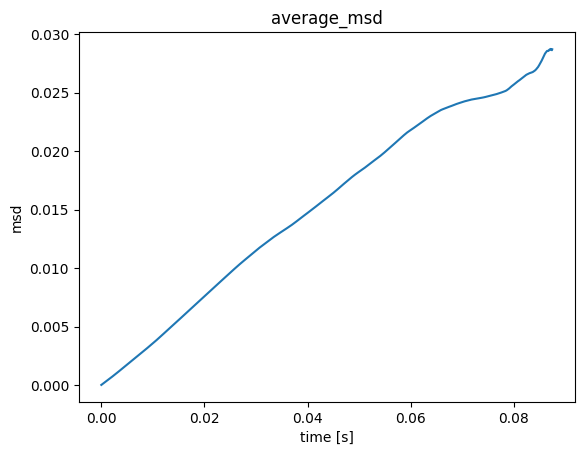

In [191]:
mean_msd = msd_W_trajs(100,1500)
t = np.arange(len(mean_msd))*dt_s
plt.plot(t,mean_msd)
plt.xlabel('time [s]')
plt.ylabel('msd')
plt.title('average_msd')
plt.show()

R-squared: 0.9984805238243748
Error Range (95% CI): 0.18696648974801564 to 0.18749083857861884
rot_diffusion_coefficient 0.18722866416331724 rotational_einstein_diffusion 0.16480238117707385


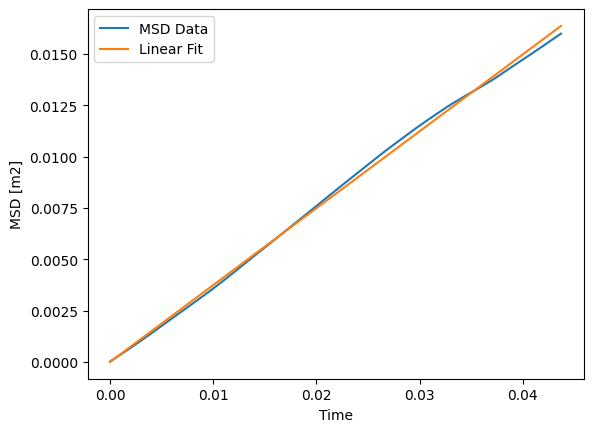

In [192]:
# Fiting the msd

def linear_fit(t, D):
    return 2 * D * t

# Reducing the array for a better fit
mean_msd = mean_msd[0:-int(len(mean_msd)/2)]
t = t[0:-int(len(t)/2)]

initial_guess = rotational_einstein_diff

# Perform the fit
params, covariance = curve_fit(linear_fit, t, mean_msd, p0=initial_guess)

# Extract the diffusion coefficient
rot_diffusion_coefficient = params[0]

#Confidence interval:
residuals = mean_msd - linear_fit(t, rot_diffusion_coefficient)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((mean_msd - np.mean(mean_msd))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R-squared:", r_squared)

std_errors = np.sqrt(np.diag(covariance))
confidence_interval = 1.96 * std_errors  # for 95% confidence interval

print("Error Range (95% CI):", rot_diffusion_coefficient - confidence_interval[0], "to", rot_diffusion_coefficient + confidence_interval[0])
print("rot_diffusion_coefficient",rot_diffusion_coefficient,"rotational_einstein_diffusion",rotational_einstein_diff)
plt.plot(t, mean_msd, label='MSD Data')
plt.plot(t, linear_fit(t , rot_diffusion_coefficient), label='Linear Fit')
plt.xlabel('Time')
plt.ylabel('MSD [m2]')
plt.legend()
plt.show()

Determination of diffusion coefficient in periodic potential

In [193]:
# Additionnal physical parameters:
space_step = 1e-12
amplitude_J = 10*k_b*T_K
amplitude1 = 1.5*k_b*T_K
amplitude2 = 2*k_b*T_K
amplitude3 = 3*k_b*T_K
frequency = 26

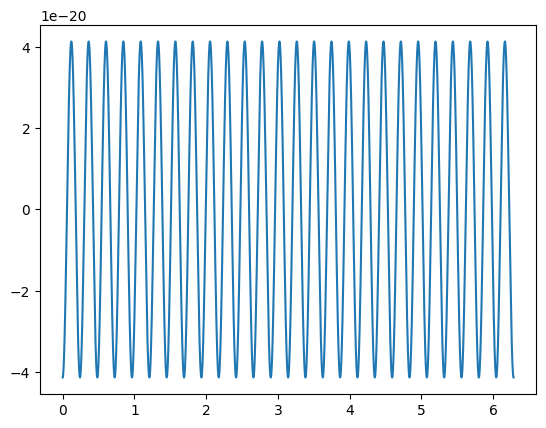

In [194]:
def periodic_potential(A,x):
    return -A*np.cos(x*frequency)
X = np.linspace(0,2*np.pi,10000)
plt.plot(X,periodic_potential(amplitude_J,X))
plt.show()

In [195]:
def static_process(N,A):
    x = 0
    stored_position = []
    w = generate_seq(N)
    for i in np.arange(0,N):
        dx = -(1/rotational_drag)*dt_s*(periodic_potential(A,x+space_step) - periodic_potential(A,x))/space_step
        dx = dx + np.sqrt(2*rotational_einstein_diff*dt_s)*w[i]
        x = np.mod(x + dx, 2*np.pi)
        stored_position.append(x)
        dx = 0
    return stored_position

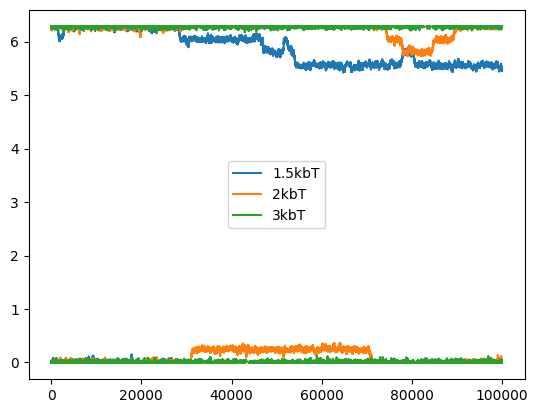

In [198]:

traj01 = static_process(100000, amplitude1)
traj02 = static_process(100000, amplitude2)
traj03 = static_process(100000, amplitude3)

def discontinuous(traj):
    ntraj = traj
    for i in range(len(ntraj)-1):
        if abs(ntraj[i+1]-ntraj[i])> np.pi:
            ntraj[i+1] = np.nan
    return ntraj
            
        
traj1 = discontinuous(traj01) 
traj2 = discontinuous(traj02)
traj3 = discontinuous(traj03)
time_axis = np.linspace(0, len(traj01), len(traj01))
plt.plot(time_axis, traj1, label='1.5kbT')
plt.plot(time_axis, traj2, label='2kbT')
plt.plot(time_axis, traj3, label='3kbT')
plt.legend()
plt.show()

In [ ]:
def msd_U_trajs(W,N):
    msd_list = []
    mean_msd = np.zeros(N-1)
    for j in range(W):
        traj = static_process(N,amplitude_J)
        msd_list.append(mean_square_displacement(traj))
    for msd in msd_list:
        mean_msd = np.add(mean_msd,msd)
    mean_msd *= 1/W
    median_position= traj[int(len(traj)/2)]
    return mean_msd,median_position

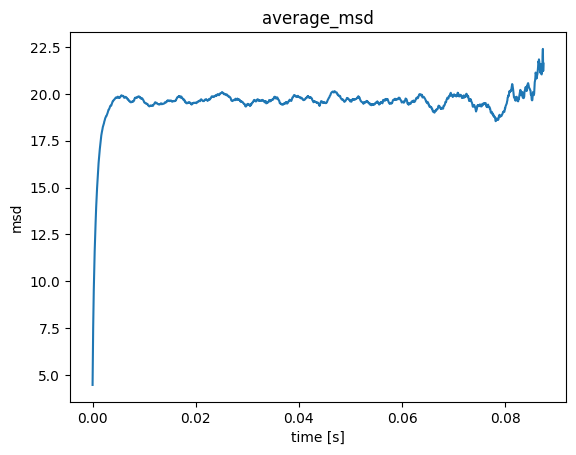

In [ ]:
mean_msd,median_position = msd_U_trajs(100,1500)
t = np.arange(len(mean_msd))*dt_s
plt.plot(t,mean_msd)
plt.xlabel('time [s]')
plt.ylabel('msd')
plt.title('average_msd')
plt.show()

R-squared: -45.26338498019573
Error Range (95% CI): 323.7443620045272 to 350.38212291449094
periodic_rotational_diffusion_coefficient 337.06324245950907 rotational_einstein_diffusion 0.16480238117707385


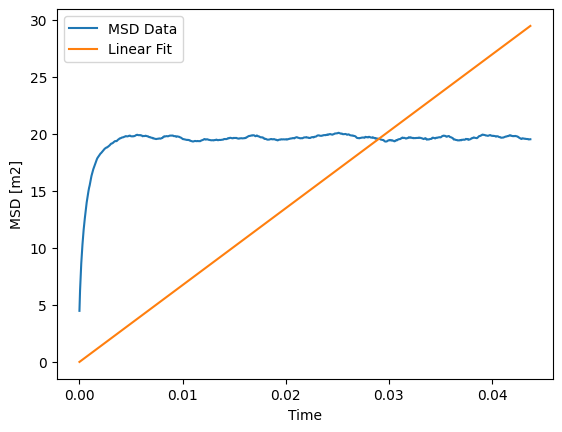

In [ ]:
def linear_fit(t, D):
    return 2 * D * t

initial_guess = rotational_einstein_diff
# Reducing the array for a better fit
mean_msd = mean_msd[0:-int(len(mean_msd)/2)]
t = t[0:-int(len(t)/2)]
# Perform the fit
params, covariance = curve_fit(linear_fit, t, mean_msd, p0=initial_guess)

# Extract the diffusion coefficient
rot_diffusion_coefficient = params[0]

#Confidence interval:
residuals = mean_msd - linear_fit(t, rot_diffusion_coefficient)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((mean_msd - np.mean(mean_msd))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R-squared:", r_squared)

std_errors = np.sqrt(np.diag(covariance))
confidence_interval = 1.96 * std_errors  # for 95% confidence interval

print("Error Range (95% CI):", rot_diffusion_coefficient - confidence_interval[0], "to", rot_diffusion_coefficient + confidence_interval[0])
print("periodic_rotational_diffusion_coefficient",rot_diffusion_coefficient,"rotational_einstein_diffusion",rotational_einstein_diff)
plt.plot(t, mean_msd, label='MSD Data')
plt.plot(t, linear_fit(t , rot_diffusion_coefficient), label='Linear Fit')
plt.xlabel('Time')
plt.ylabel('MSD [m2]')
plt.legend()
plt.show()